In [1]:
assignment_path = '/content/gdrive/My Drive/CIS680_2021/Project'
  
# Mount your drive
from google.colab import drive
drive.mount("/content/gdrive")

# Setup assignment folder and switch
import os
# from utils import *

os.makedirs(assignment_path, exist_ok=True)
os.chdir(assignment_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!ls

backbone.py	   model10.pt	model6V2.pt		 modelsimon2.pth
BoxHead.py	   model1V2.pt	model7V2.pt		 pretrained_models.py
checkpoint680.pth  model2V2.pt	model8V2.pt		 __pycache__
data		   model3V2.pt	model9V2.pt		 rpn.py
dataset.py	   model4V2.pt	modelcodesubmission.pth  utils.py
MaskHead.py	   model5V2.pt	modelsimon1.pth


In [3]:
from dataset import *
import cv2
from utils import output_decoding
# we will need the ImageList from torchvision
from torchvision.models.detection.image_list import ImageList


imgs_path = 'data/hw3_mycocodata_img_comp_zlib.h5'
masks_path = 'data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = "data/hw3_mycocodata_labels_comp_zlib.npy"
bboxes_path = "data/hw3_mycocodata_bboxes_comp_zlib.npy"

paths = [imgs_path, masks_path, labels_path, bboxes_path]
# load the data into data.Dataset
dataset = BuildDataset(paths)

# Standard Dataloaders Initialization
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size

torch.random.manual_seed(1)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 2
print("batch size:", batch_size)
test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()

batch size: 2


In [4]:
from pretrained_models import pretrained_models_680
import torch
pretrained_path='checkpoint680.pth'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
backbone, rpn = pretrained_models_680(pretrained_path)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


For the proposals We have a list containing 2 tensors
Each one with shape torch.Size([20, 4])

For the features we have a list of features for each FPN level with shapes
torch.Size([2, 256, 200, 272])
torch.Size([2, 256, 100, 136])
torch.Size([2, 256, 50, 68])
torch.Size([2, 256, 25, 34])
torch.Size([2, 256, 13, 17])


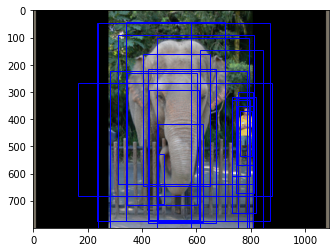

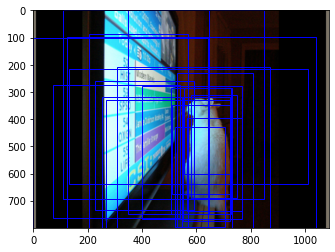

In [5]:
# Here we keep the top 20, but during training you should keep around 200 boxes from the 1000 proposals
keep_topK=20

with torch.no_grad():
    for iter, batch in enumerate(test_loader, 0):
        images = batch[0].to(device)

        # Take the features from the backbone
        backout = backbone(images)

        # The RPN implementation takes as first argument the following image list
        im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
        # Then we pass the image list and the backbone output through the rpn
        rpnout = rpn(im_lis, backout)

        #The final output is
        # A list of proposal tensors: list:len(bz){(keep_topK,4)}
        proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
        # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
        fpn_feat_list= list(backout.values())

        print("For the proposals We have a list containing "+str(len(proposals))+" tensors")
        print("Each one with shape "+str(proposals[0].shape))
        print("")
        print("For the features we have a list of features for each FPN level with shapes")
        for feat in fpn_feat_list:
            print(feat.shape)


        # Visualization of the proposals
        for i in range(batch_size):
            img_squeeze = transforms.functional.normalize(images[i,:,:,:].to('cpu'),
                                                          [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                                                          [1 / 0.229, 1 / 0.224, 1 / 0.225], inplace=False)
            fig,ax=plt.subplots(1,1)
            ax.imshow(img_squeeze.permute(1,2,0))


            for box in proposals[i]:
                box=box.view(-1)
                rect=patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],fill=False,color='b')
                ax.add_patch(rect)
            plt.show()

        break

#model setup

In [6]:
current_device='cuda:0'
device='cuda:0'

In [7]:
import torch
import torch.nn.functional as F
from torch import nn
from utils import *
from sklearn.metrics import auc
import colorsys
import random

class BoxHead(torch.nn.Module):
    def __init__(self,Classes=3,P=7):
        super(BoxHead,self).__init__()
        self.C=Classes
        self.P=P
        self.device = "cuda"
        # TODO initialize BoxHead
        self.intermediate = nn.ModuleList()
        self.intermediate.append(nn.Linear(256*self.P*self.P, 1024,device=current_device))
        self.intermediate.append(nn.ReLU())
        self.intermediate.append(nn.Linear(1024, 1024,device=current_device))
        self.intermediate.append(nn.ReLU())

        self.classifier = nn.ModuleList()
        self.classifier.append(nn.Linear(1024, self.C+1,device=current_device))
        # self.classifier.append(nn.Softmax(dim=1))

        self.regressor = nn.Linear(1024, 4*self.C,device=current_device)

    #  This function assigns to each proposal either a ground truth box or the background class (we assume background class is 0)
    #  Input:
    #       proposals: list:len(bz){(per_image_proposals,4)} ([x1,y1,x2,y2] format)
    #       gt_labels: list:len(bz) {(n_obj)}
    #       bbox: list:len(bz){(n_obj, 4)}
    #  Output: (make sure the ordering of the proposals are consistent with MultiScaleRoiAlign)
    #       labels: (total_proposals,1) (the class that the proposal is assigned)
    #       regressor_target: (total_proposals,4) (target encoded in the [t_x,t_y,t_w,t_h] format)
    def create_ground_truth(self,proposals,gt_labels,bbox):
        ground_clas, ground_reg = MultiApply(self.create_ground_truth_image, proposals,gt_labels,bbox)
        labels = torch.cat(ground_clas, dim=0)
        regressor_target = torch.cat(ground_reg, dim=0)
        
        return labels,regressor_target

    def create_ground_truth_image(self, proposals_img,gt_labels_img,bbox_img):
        ious = []
        gt_labels_img = gt_labels_img.to(self.device)
        bbox_img = bbox_img.to(self.device)
        bbox_img_xywh = convert_xywh(bbox_img)
        proposals_img_xywh = convert_xywh(proposals_img)
        for bbox in bbox_img:
            iou = IOU(proposals_img, bbox)
            ious.append(iou)
        ious = torch.stack(ious, 1).to(self.device)
        ground_clas = torch.zeros(len(proposals_img), device=self.device)
        ground_reg = torch.zeros((len(proposals_img), 4), device=self.device)
        ious_max = ious.max(dim=1)
        ground_clas[ious_max.values > 0.5] = gt_labels_img[ious_max.indices[ious_max.values > 0.5]]
        ground_reg[ious_max.values > 0.5] = bbox_img_xywh[ious_max.indices[ious_max.values > 0.5]]
        encoded_reg = torch.zeros_like(ground_reg)
        encoded_reg[:, 0] = (ground_reg[:, 0] - proposals_img_xywh[:, 0]) / proposals_img_xywh[:, 2]
        encoded_reg[:, 1] = (ground_reg[:, 1] - proposals_img_xywh[:, 1]) / proposals_img_xywh[:, 3]
        encoded_reg[:, 2] = torch.log(ground_reg[:, 2]/proposals_img_xywh[:, 2])
        encoded_reg[:, 3] = torch.log(ground_reg[:, 3]/proposals_img_xywh[:, 3])
        ground_reg[ground_clas>0] = encoded_reg[ground_clas>0]

        return ground_clas, ground_reg

    # This function for each proposal finds the appropriate feature map to sample and using RoIAlign it samples
    # a (256,P,P) feature map. This feature map is then flattened into a (256*P*P) vector
    # Input:
    #      fpn_feat_list: list:len(FPN){(bz,256,H_feat,W_feat)}
    #      proposals: list:len(bz){(per_image_proposals,4)} ([x1,y1,x2,y2] format)
    #      P: scalar
    # Output:
    #      feature_vectors: (total_proposals, 256*P*P)  (make sure the ordering of the proposals are the same as the ground truth creation)
    def MultiScaleRoiAlign(self, fpn_feat_list,proposals,P=7):
        fpn_boxes = [[],[],[],[]]           #For each level of feature pyramid
        orig_height= 800 
        orig_width = 1088
        feature_vectors=[]
        for i in range(len(proposals)):
            for j in range(proposals[i].shape[0]):
                x1,y1,x2,y2 = proposals[i][j]
                w = x2-x1
                h = y2-y1
                k = torch.clip(torch.floor(4+torch.log2(torch.sqrt(w*h)/224)),2,5).int()
            
                stride_x = orig_width/fpn_feat_list[k-2].shape[3]
                stride_y = orig_height/fpn_feat_list[k-2].shape[2]

                box = proposals[i][j].reshape(1,-1).clone()
                box[:,0] = box[:,0] / stride_x 
                box[:,2] = box[:,2] / stride_x
                box[:,1] = box[:,1] / stride_y
                box[:,3] = box[:,3] / stride_y
                # import pdb; pdb.set_trace()   
                inp = fpn_feat_list[k-2][i].unsqueeze(0)  # dim: (1,256,H_feat,W_feat)
                op  = torchvision.ops.roi_align(inp, [box], output_size=P, 
                                      spatial_scale=1,
                                      sampling_ratio=-1)  # dim : (1,256,P,P)

                feature_vectors.append(op.view(-1))
                #fpn_boxes[k-2].append(element)
        
        feature_vectors = torch.stack(feature_vectors, dim=0) #dim = (total_proposals, 256*P*P)
        
        '''
        output = [] #Dim len(fpn_list), element: tensor: (K,C,P,P)
        for i, level in enumerate(fpn_boxes):
            level_proposals = torch.stack(level,dim=1)[0][:,1:6]   # dim: (K,5) 
            output.append(torchvision.ops.roi_align(fpn_feat_list[i], level_proposals, output_size=P, 
                                      spatial_scale=orig_height/fpn_feat_list[i].shape[2],
                                      sampling_ratio=4))
            
        '''  
            
        return feature_vectors




    # This function does the post processing for the results of the Box Head for a batch of images
    # Use the proposals to distinguish the outputs from each image
    # Input:
    #       class_logits: (total_proposals,(C+1))
    #       box_regression: (total_proposal,4*C)           ([t_x,t_y,t_w,t_h] format)
    #       proposals: list:len(bz)(per_image_proposals,4) (the proposals are produced from RPN [x1,y1,x2,y2] format)
    #       conf_thresh: scalar
    #       keep_num_preNMS: scalar (number of boxes to keep pre NMS)
    #       keep_num_postNMS: scalar (number of boxes to keep post NMS)
    # Output:
    #       boxes: list:len(bz){(post_NMS_boxes_per_image,4)}  ([x1,y1,x2,y2] format)
    #       scores: list:len(bz){(post_NMS_boxes_per_image)}   ( the score for the top class for the regressed box)
    #       labels: list:len(bz){(post_NMS_boxes_per_image)}   (top class of each regressed box)
    def postprocess_detections(self, class_logits, box_regression, proposals, conf_thresh=0.5, keep_num_preNMS=500, keep_num_postNMS=50):
        boxes,scores,labels = [],[],[]

        j = 0
        for batch_id in range(len(proposals)):
          one_proposal = proposals[batch_id]
          one_score = class_logits[j:j +one_proposal.shape[0], :]
          one_box = box_regression[j:j +one_proposal.shape[0], :]
          j += one_proposal.shape[0]
          one_score[:,0]=-1000
          one_label = torch.argmax(one_score, dim=1)  - 1

          temp = torch.zeros(one_proposal.shape)
          temp[:, 0] = (one_proposal[:, 0] + one_proposal[:, 2]) / 2.0
          temp[:, 1] = (one_proposal[:, 1] + one_proposal[:, 3]) / 2.0
          temp[:, 2] = one_proposal[:, 2] - one_proposal[:, 0]
          temp[:, 3] = one_proposal[:, 3] - one_proposal[:, 1]
          one_proposal_center=temp.to(device)
 
          bbox_temp = torch.zeros((one_box.shape[0],4)).to(device)            
          bbox_corner = torch.zeros(one_box.shape).to(device)
          for i in range(3):
            bbox_temp[:,0] = one_box[:, 0 + i * 4] *  one_proposal_center[:, 2] + one_proposal_center[:, 0]
            bbox_temp[:,1] = one_box[:, 1 + i * 4] * one_proposal_center[:, 3] + one_proposal_center[:, 1]
            bbox_temp[:,2] = torch.exp(one_box[:, 2 + i * 4]) * one_proposal_center[:, 2]
            bbox_temp[:,3] = torch.exp(one_box[:, 3 + i * 4]) * one_proposal_center[:, 3]
            temp = torch.zeros(bbox_temp.shape)
            temp[:, 0] = bbox_temp[:, 0] - bbox_temp[:, 2] / 2
            temp[:, 1] = bbox_temp[:, 1] - bbox_temp[:, 3] / 2
            temp[:, 2] = bbox_temp[:, 0] + bbox_temp[:, 2] / 2
            temp[:, 3] = bbox_temp[:, 1] + bbox_temp[:, 3] / 2
            bbox_corner[:, i * 4:i * 4 + 4] =temp.to(device)
            bbox_corner[:, i * 4] = torch.min(bbox_corner[:, i * 4],1088 * torch.ones(bbox_corner[:, i * 4].shape).to(device))
            bbox_corner[:, i * 4 + 2] = torch.min(bbox_corner[:, i * 4 + 2],1088 * torch.ones(bbox_corner[:, i * 4].shape).to(device))
            bbox_corner[:, i * 4 + 1] = torch.min(bbox_corner[:, i * 4 + 1],800 * torch.ones(bbox_corner[:, i * 4].shape).to(device))
            bbox_corner[:, i * 4 + 3] = torch.min(bbox_corner[:, i * 4 + 3],800 * torch.ones(bbox_corner[:, i * 4].shape).to(device))
          bbox_corner = torch.max(bbox_corner, torch.zeros(bbox_corner.shape).to(device))

          max_bbox = torch.zeros(bbox_corner.shape[0],4).to(device)
          max_score = torch.max(one_score, dim=1).values.to(device)

          for i in range(max_bbox.shape[0]):
            # print("i",i)
            # print(bbox_corner[i,],one_label[i],"sbc", bbox_corner[i, one_label[i] * 4:one_label[i] * 4 + 4])
            # print(max_bbox)
            # if one_label[i]==-1:
            #   continue

            max_bbox[i, :] =  bbox_corner[i, (one_label[i]) * 4:(one_label[i]) * 4 + 4]
          # print(max_bbox)

          sorted_score = torch.argsort(max_score, descending=True)
          k_score =  max_score[sorted_score[:keep_num_preNMS]]
          k_bbox = max_bbox[sorted_score[:keep_num_preNMS]]
          k_label = one_label[sorted_score[:keep_num_preNMS]]
          # print("idx",sorted_score[0:3])
          # print("bef",max_bbox[sorted_score[:3]])
          # print("Af",k_bbox==max_bbox)
          def NMS( clas, prebox):
            iou = matrix_IOU(prebox.repeat(prebox.shape[0], 1, 1), prebox.repeat(prebox.shape[0], 1, 1).permute(1, 0, 2), device=device).triu(diagonal=1)
            iou_one = torch.max(iou, dim=0).values.expand(prebox.shape[0], prebox.shape[0]).T
            return torch.min((1 - iou) / (1 - iou_one), dim=0).values * clas
          # print(torchvision.ops.nms(k_bbox,k_score,0.5))
          post_nms = torch.argsort(NMS(k_score, k_bbox), descending=True)
          # print(post_nms,keep_num_postNMS)

          # print(post_nms)
          post_nms=torchvision.ops.nms(k_bbox,k_score,0.05)
          boxes.append(k_bbox[post_nms[:keep_num_postNMS]])
          scores.append(k_score[post_nms[:keep_num_postNMS]])
          labels.append(k_label[post_nms[:keep_num_postNMS]])

        return boxes, scores, labels

    def IOU2(self,boxA, boxB):
        inter_x1 = max(boxA[0], boxB[0])
        inter_y1 = max(boxA[1], boxB[1])
        inter_x2 = min(boxA[2], boxB[2])
        inter_y2 = min(boxA[3], boxB[3])
        area_boxA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
        area_boxB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
        inter = max((inter_x2 - inter_x1), 0) * max((inter_y2 - inter_y1), 0)
        iou = inter / (area_boxA + area_boxB - inter + 1)
        return iou
    
    def evaluation(self,nms_boxes,nms_scores,nms_labels,gt_boxes,gt_labels,iou_thresh= 0.5) :
        matches,scores = [], []
        num_trues ,num_positives= torch.zeros(1, 3),torch.zeros(1, 3)
        for batch_id in range(len(nms_labels)):
          match,score = torch.zeros(nms_labels[batch_id].shape[0], 3),torch.zeros(nms_labels[batch_id].shape[0], 3)
          num_true,num_positive = torch.zeros(1, 3), torch.zeros(1, 3)
          for one_label in gt_labels[batch_id]:
            if one_label > 0:
              num_true[0, one_label.type(torch.int32) - 1] += 1
          for one_label in nms_labels[batch_id]:
            num_positive[0, one_label.type(torch.int32)] += 1
          for pred, class_pred in enumerate(nms_labels[batch_id]):
            if class_pred.item() + 1 in gt_labels[batch_id]:
              gt_list = (gt_labels[batch_id] == class_pred +1).nonzero(as_tuple=False).squeeze(0)
              for gt_one in gt_list:
                box_pred = nms_boxes[batch_id][pred]
                box_gt = gt_boxes[batch_id][gt_one.item()]
                if self.IOU2(box_pred, box_gt) > iou_thresh:
                  match[pred, class_pred] = 1
            score[pred, class_pred] = nms_scores[batch_id][pred]
          matches.append(match)
          scores.append(score)
          num_trues = torch.cat([num_trues, num_true], dim=0)
          num_positives = torch.cat([num_positives, num_positive], dim=0)

        return torch.cat(matches), torch.cat(scores), torch.sum(num_trues, dim=0), torch.sum(num_positives, dim=0)

    def ap(self,match_values,score_values,total_trues,total_positives,threshold=0.5):
        area, sorted_recall, sorted_precision = 0, 0, 0
        max_score = torch.max(score_values).item()
        ln = torch.linspace(threshold, max_score, steps=100)
        precision_mat = torch.zeros(101)
        recall_mat = torch.zeros(101)
        for i, th in enumerate(ln):
          matches = match_values[score_values > th]
          TP = torch.sum(matches)  
          precision = 1
          if total_positives > 0:
            precision = TP / total_positives
          recall = 1
          if total_trues > 0:
            recall = TP / total_trues
          precision_mat[i] = precision
          recall_mat[i] = recall
        recall_mat[100] = 0
        precision_mat[100] = 1
        sorted_idx = torch.argsort(recall_mat)
        sorted_recall = recall_mat[sorted_idx]
        sorted_idx = torch.argsort(recall_mat,descending=True)
        sorted_precision = precision_mat[sorted_idx]
        area = auc(sorted_recall, sorted_precision)
        return area, sorted_recall, sorted_precision

    # Compute the total loss of the classifier and the regressor
    # Input:
    #      class_logits: (total_proposals,(C+1)) (as outputed from forward, not passed from softmax so we can use CrossEntropyLoss)
    #      box_preds: (total_proposals,4*C)      (as outputed from forward)
    #      labels: (total_proposals,1)
    #      regression_targets: (total_proposals,4)
    #      l: scalar (weighting of the two losses)
    #      effective_batch: scalar
    # Outpus:
    #      loss: scalar
    #      loss_class: scalar
    #      loss_regr: scalar
    def compute_loss(self,class_logits, box_preds, labels, regression_targets,l=1,effective_batch=150):
        labels = labels.type(torch.LongTensor)
        find_cor=(labels>0).nonzero().view(-1).to(self.device)
        find_neg=(labels==0).nonzero().view(-1).to(self.device)
        n_pos = len(find_cor)
        n_neg = len(find_neg)
        
        find_cor = find_cor[torch.randperm(n_pos)][:min(effective_batch//4, n_pos)]
        find_neg = find_neg[torch.randperm(n_neg)][:max(effective_batch-effective_batch//4, effective_batch-n_pos)]

        labels_out = torch.cat([labels[find_cor], labels[find_neg]]).to(self.device)
        logits_out = torch.cat([class_logits[find_cor], class_logits[find_neg]])

        box_pred_out = box_preds[find_cor].reshape((len(find_cor), 3, 4))
        box_pred_out = box_pred_out[torch.arange(len(find_cor)),labels[find_cor]-1,:]
        regressor_target_out = regressor_target[find_cor]

        loss_class = F.cross_entropy(logits_out, labels_out)
        criterion =  torch.nn.SmoothL1Loss(reduction="sum")
        loss_regr = criterion(box_pred_out, regressor_target_out) / len(find_cor)
        loss = loss_class + l*loss_regr

        return loss, loss_class, l*loss_regr



    # Forward the pooled feature vectors through the intermediate layer and the classifier, regressor of the box head
    # Input:
    #        feature_vectors: (total_proposals, 256*P*P)
    # Outputs:
    #        class_logits: (total_proposals,(C+1)) (we assume classes are C classes plus background, notice if you want to use
    #                                               CrossEntropyLoss you should not pass the output through softmax here)
    #        box_pred:     (total_proposals,4*C)
    def forward(self, feature_vectors):
        X = feature_vectors
        # print(X.device)
        for i, layer in enumerate(self.intermediate):
            # print(i,X.device)
            # print(layer,layer.device)
            X = layer(X).to(device=current_device)
        # print("inter",X.device)
        #TODO forward through the Classifier Head
        class_logits = X
        for i, layer in enumerate(self.classifier):
            class_logits = layer(class_logits).to(device=current_device)
        # print('logit',class_logits.device)

        #TODO forward through the Regressor Head
        box_pred = X.to(device=current_device)
        box_pred = self.regressor(box_pred)
        # print('box',box_pred.device)
        return class_logits, box_pred

In [8]:
import torch
import torch.nn.functional as F
from torch import nn
from utils import *

class MaskHead(torch.nn.Module):
    def __init__(self,Classes=3,P=14):
        super(MaskHead,self).__init__()
        self.C=Classes
        self.P=P
        # TODO initialize MaskHead
        self.network = nn.ModuleList()
        for _ in range(4):
            self.network.append(nn.Conv2d(256, 256, 3, padding="same",device=current_device))
            self.network.append(nn.ReLU())
        self.network.append(nn.ConvTranspose2d(256, 256, 2, 2, 0,device=current_device))
        self.network.append(nn.ReLU())
        self.network.append(nn.Conv2d(256, self.C, 1, 1, 0,device=current_device))
        self.network.append(nn.Sigmoid())


    # general function that takes the input list of tensors and concatenates them along the first tensor dimension
    # Input:
    #      input_list: list:len(bz){(dim1,?)}
    # Output:
    #      output_tensor: (sum_of_dim1,?)
    def flatten_inputs(self,input_list):
        output_tensor = torch.cat(input_list, dim=0)
        return output_tensor


    # Compute the total loss of the Mask Head
    # Input:
    #      mask_output: (total_boxes,C,2*P,2*P)
    #      labels: (total_boxes)
    #      gt_masks: (total_boxes,2*P,2*P)
    # Output:
    #      mask_loss
    def compute_loss(self,mask_output,labels,gt_masks):
        # total_boxes = len(labels)
        # criterion = nn.BCELoss(reduction="sum")
        # mask_output_C = mask_output[torch.arange(total_boxes), (labels-1).type(torch.LongTensor), :,:]
        # mask_loss = criterion(mask_output_C, gt_masks)
        # mask_loss = mask_loss / total_boxes
        # return mask_loss
        total_boxes = len(labels)
        criterion = nn.BCELoss(reduction="mean")
        # only looking at masks corresponding to positive samples
        find_cor = (labels>0).nonzero().view(-1).to(device)
        mask_output_C = mask_output[find_cor, (labels[find_cor]-1).type(torch.LongTensor), :,:]
        mask_loss = criterion(mask_output_C, mask_target[find_cor])
        return mask_loss


    def evaluation(self,nms_boxes,nms_scores,nms_labels,gt_boxes,gt_labels,iou_thresh= 0.5) :
      
        def compute_overlaps_masks(masks1, masks2):
            #input is np
            masks1=np.transpose(masks1,(1,2,0))
            masks2=np.transpose(masks2,(1,2,0))
            masks1 = np.reshape(masks1 > .5, (-1, masks1.shape[-1])).astype(np.float32)
            masks2 = np.reshape(masks2 > .5, (-1, masks2.shape[-1])).astype(np.float32)
            area1 = np.sum(masks1, axis=0)
            area2 = np.sum(masks2, axis=0)

            intersections = np.dot(masks1.T, masks2)
            union = area1[:, None] + area2[None, :] - intersections
            overlaps = intersections / union

            return overlaps

        matches,scores = [], []
        num_trues ,num_positives= torch.zeros(1, 3),torch.zeros(1, 3)
        # for batch_id in range(len(nms_labels)):
        match,score = torch.zeros(nms_labels.shape[0], 3),torch.zeros(nms_labels.shape[0], 3)
        num_true,num_positive = torch.zeros(1, 3), torch.zeros(1, 3)
        for one_label in gt_labels:
          if one_label > 0:
            num_true[0, int(one_label) - 1] += 1
        for one_label in nms_labels:
          num_positive[0, int(one_label)] += 1
        for pred, class_pred in enumerate(nms_labels):
          if class_pred.item()  in gt_labels:
            gt_list = (gt_labels == class_pred ).nonzero(as_tuple=False).squeeze(0)
            for gt_one in gt_list:

              box_pred = nms_boxes[pred]

              box_gt = gt_boxes[gt_one.item()]
              
              # print(compute_overlaps_masks(np.expand_dims(box_pred,0),np.expand_dims(box_gt,0)))
              if compute_overlaps_masks(np.expand_dims(box_pred,0),np.expand_dims(box_gt,0)) > iou_thresh:
                match[pred, class_pred] = 1
          
          score[pred, class_pred] = torch.tensor(nms_scores[pred]).to(score)
          
        matches.append(match)
        scores.append(score)
        num_trues = torch.cat([num_trues, num_true], dim=0)
        num_positives = torch.cat([num_positives, num_positive], dim=0)

        return torch.cat(matches), torch.cat(scores), torch.sum(num_trues, dim=0), torch.sum(num_positives, dim=0)

    def ap(self,match_values,score_values,total_trues,total_positives,threshold=0.5):
        area, sorted_recall, sorted_precision = 0, 0, 0
        max_score = torch.max(score_values).item()
        ln = torch.linspace(threshold, max_score, steps=100)
        precision_mat = torch.zeros(101)
        recall_mat = torch.zeros(101)
        for i, th in enumerate(ln):
          matches = match_values[score_values > th]
          TP = torch.sum(matches)  
          precision = 1
          if total_positives > 0:
            precision = TP / total_positives
          recall = 1
          if total_trues > 0:
            recall = TP / total_trues
          precision_mat[i] = precision
          recall_mat[i] = recall
        recall_mat[100] = 0
        precision_mat[100] = 1
        sorted_idx = torch.argsort(recall_mat)
        sorted_recall = recall_mat[sorted_idx]
        sorted_idx = torch.argsort(recall_mat,descending=True)
        sorted_precision = precision_mat[sorted_idx]
        area = auc(sorted_recall, sorted_precision)
        return area, sorted_recall, sorted_precision


    # Forward the pooled feature map Mask Head
    # Input:
    #        features: (total_boxes, 256,P,P)
    # Outputs:
    #        mask_outputs: (total_boxes,C,2*P,2*P)
    def forward(self, features):
        for i, layer in enumerate(self.network):
            features = layer(features)

        return features

    #  This function assigns to each proposal either a ground truth box or the background class (we assume background class is 0)
    #  Input:
    #       proposals: list:len(bz){(per_image_proposals,4)} ([x1,y1,x2,y2] format)
    #       gt_labels: list:len(bz) {(n_obj)}
    #       bbox: list:len(bz){(n_obj, 4)}
    #       masks: list:len(bz){(n_obj, 800, 1088)}
    #  Output: (make sure the ordering of the proposals are consistent with MultiScaleRoiAlign)
    #       labels: (total_proposals,1) (the class that the proposal is assigned)
    #       regressor_target: (total_proposals,4) (target encoded in the [t_x,t_y,t_w,t_h] format)
    #       mask_target: (total_proposals,2*P,2*P)

    def create_ground_truth(self,box_regression,labels,proposals,bbox,masks):
        box_regression_list = [box_regression[i*keep_topK:(i+1)*keep_topK] for i in range(len(proposals))]
        labels = labels.type(torch.LongTensor)
        labels_list = [labels[i*keep_topK:(i+1)*keep_topK] for i in range(len(proposals))]

        ground_mask, _ = MultiApply(self.create_ground_truth_image,box_regression_list,labels_list,proposals,bbox,masks)
        mask_target = torch.cat(ground_mask, dim=0)
        # print(mask_target.shape,labels.shape )
        return mask_target

    def create_ground_truth_image(self, box_regression_img,labels,proposals_img,bbox_img,masks_img):
        # find max predicted class
        # max_class_img = class_logits_img.max(dim=1)
        # find_cor = (max_class_img.indices>0).nonzero().view(-1).to(device)
        # get the predicted box for the max class
        box_output = torch.zeros((len(proposals_img), 4), device=device)
        for i in range(len(proposals_img)):
            # class_idx = max_class_img.indices[i] 
            class_idx = labels[i]
            if class_idx == 0:
                continue
            box_output[i] = box_regression_img[i, 4*(class_idx-1):4*class_idx]

        # decode the box regression to x1 y1 x2 y2 format
        proposals_img_xywh = convert_xywh(proposals_img)
        box_output_xyxy = output_decoding(box_output, proposals_img_xywh).to(device)

        # calculate each box regreesion's IOU with gt boxes
        ious = []
        box_output_xywh = convert_xywh(box_output_xyxy)
        for bbox in bbox_img:
            iou = IOU(box_output_xyxy, bbox)
            ious.append(iou)
        ious = torch.stack(ious, 1)
        ious_max = ious.max(dim=1)

        ground_mask = torch.zeros((len(proposals_img), 2*self.P, 2*self.P), device=device)
        for i in range(len(proposals_img)):
            # ignore if iou with every box is < 0.5 or predicted class is background
            if ious_max.values[i] <= 0.5 or labels[i] == 0:
                continue
            x1, y1, x2, y2 = box_output_xyxy[i]
            box_idx = ious_max.indices[i]
            gt_mask = masks_img[box_idx]
            # crop and resize
            m = gt_mask[int(y1):int(y2), int(x1):int(x2)]
            resized_m = cv2.resize(m.numpy(), (2*self.P, 2*self.P))
            ground_mask[i] = torch.round(torch.Tensor(resized_m)).to(device)
       
        return ground_mask, None



In [9]:
class MaskRCNN(torch.nn.Module):
    def __init__(self,Classes=3,P=14):
        super(MaskRCNN,self).__init__()

        self.box_head = BoxHead()
        self.mask_head = MaskHead()

    def forward(self, feature_vectors_box, feature_vectors_mask):
        class_logits, box_pred = self.box_head.forward(feature_vectors_box)
        # print(feature_vectors_mask.device)

        mask_output = self.mask_head.forward(feature_vectors_mask )
        return class_logits, box_pred, mask_output



In [10]:
def MultiScaleRoiAlign(fpn_feat_list,proposals,P=14):
    fpn_boxes = [[],[],[],[]]           #For each level of feature pyramid
    orig_height= 800 
    orig_width = 1088
    feature_vectors=[]
    for i in range(len(proposals)):
        for j in range(proposals[i].shape[0]):
            x1,y1,x2,y2 = proposals[i][j]
            w = x2-x1
            h = y2-y1
            k = torch.clip(torch.floor(4+torch.log2(torch.sqrt(w*h)/224)),2,5).int()
        
            stride_x = orig_width/fpn_feat_list[k-2].shape[3]
            stride_y = orig_height/fpn_feat_list[k-2].shape[2]

            box = proposals[i][j].reshape(1,-1).clone()
            box[:,0] = box[:,0] / stride_x 
            box[:,2] = box[:,2] / stride_x
            box[:,1] = box[:,1] / stride_y
            box[:,3] = box[:,3] / stride_y
            # import pdb; pdb.set_trace()   
            inp = fpn_feat_list[k-2][i].unsqueeze(0)  # dim: (1,256,H_feat,W_feat)
            op  = torchvision.ops.roi_align(inp, [box], output_size=P, 
                                  spatial_scale=1,
                                  sampling_ratio=-1)  # dim : (1,256,P,P)

            feature_vectors.append(op[0]) #.append(op.view(-1))
            #fpn_boxes[k-2].append(element)
    
    feature_vectors = torch.stack(feature_vectors) #dim = (total_proposals, 256*P*P)
    
    '''
    output = [] #Dim len(fpn_list), element: tensor: (K,C,P,P)
    for i, level in enumerate(fpn_boxes):
        level_proposals = torch.stack(level,dim=1)[0][:,1:6]   # dim: (K,5) 
        output.append(torchvision.ops.roi_align(fpn_feat_list[i], level_proposals, output_size=P, 
                                  spatial_scale=orig_height/fpn_feat_list[i].shape[2],
                                  sampling_ratio=4))
        
    '''  
        
    return feature_vectors


def matrix_IOU(boxA, boxB, device='cpu'):
  inter_x1 = torch.max(boxA[..., 0], boxB[..., 0])
  inter_y1 = torch.max(boxA[..., 1], boxB[..., 1])
  inter_x2 = torch.min(boxA[..., 2], boxB[..., 2])
  inter_y2 = torch.min(boxA[..., 3], boxB[..., 3])
  inter = torch.max((inter_x2 - inter_x1), torch.zeros(inter_x2.shape).to(device)) * \
      torch.max((inter_y2 - inter_y1), torch.zeros(inter_x2.shape).to(device))
  iou = inter / ((boxA[..., 2] - boxA[..., 0]) * (boxA[..., 3] - boxA[..., 1]) +
                 (boxB[..., 2] - boxB[..., 0]) *
                 (boxB[..., 3] - boxB[..., 1]) - inter + 1)
  return iou

#training

In [ ]:
from tqdm import tqdm
import cv2

device = "cuda"
backbone.to(device)
rpn.to(device)

for param in backbone.parameters():
    param.requires_grad = False
# for param in rpn.parameters():
#     param.requires_grad = False


keep_topK = 200
l = 10
lr = 0.0003
# box_head = BoxHead().to(device)
# mask_head = MaskHead().to(device)
mask_rcnn = MaskRCNN().to(device)
mask_rcnn.box_head.device = device
batch_size = 4
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader = train_build_loader.loader()
test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()
# optimizer = torch.optim.SGD(mask_rcnn.parameters(), lr=0.0003, momentum=0.9, weight_decay=1e-4)
optimizer = torch.optim.SGD(mask_rcnn.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)

# optimizer = torch.optim.Adam(mask_rcnn.parameters(), lr=0.001,  weight_decay=1e-4)

log_every = 10
train_losses = []
train_losses_m = []
train_losses_c = []
train_losses_r = []
val_losses = []
val_losses_m = []
val_losses_c = []
val_losses_r = []
start_epoch = 0 
# saved_dict = torch.load("modelV2_rpn.pt")
# start_epoch = saved_dict["epoch"]
# train_losses_m = saved_dict["train_losses_m"]
# train_losses_r = saved_dict["train_losses_r"]
# train_losses_c = saved_dict["train_losses_c"]
# val_losses_m = saved_dict["val_losses_m"]
# val_losses_r = saved_dict["val_losses_r"]
# val_losses_c = saved_dict["val_losses_c"]
# mask_rcnn.load_state_dict(saved_dict["state_dict"])
# optimizer.load_state_dict(saved_dict["optimizer"])
# rpn.load_state_dict(saved_dict["rpn"])
# print("starting from epoch", start_epoch)


starting from epoch 12


In [ ]:
epochs = 10
for epoch in range(start_epoch, epochs):
    if epoch >= 5:
        for g in optimizer.param_groups:
            g['lr'] = lr / 3
    # model = train_one_epoch(model, train_loader)
    mask_rcnn.train()
    loss_log = 0
    loss_log_c = 0
    loss_log_r = 0
    loss_log_m = 0
    pbar = tqdm(train_loader)
    # pbar = enumerate(pbar,0)
    for i,batch in enumerate(pbar,0):

        mask_rcnn.zero_grad()
        images, labels, masks, bboxes_list, indexes = batch
        images = images.to(device)

        bboxes_list = [b.to(device) for b in bboxes_list]
        backout = backbone(images)

        # The RPN implementation takes as first argument the following image list
        im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
        # Then we pass the image list and the backbone output through the rpn
        rpnout = rpn(im_lis, backout)

        #The final output is
        # A list of proposal tensors: list:len(bz){(keep_topK,4)}
        proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
        # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
        fpn_feat_list= list(backout.values())

        feature_vectors_box = mask_rcnn.box_head.MultiScaleRoiAlign(fpn_feat_list,proposals)
        # class_logits, box_pred = box_head.forward(feature_vectors_box)
        # print(class_logits)
        
        feature_vectors_mask = MultiScaleRoiAlign(fpn_feat_list,proposals,P=14)
        # mask_output = mask_head.forward(feature_vectors_mask)

        class_logits, box_pred, mask_output = mask_rcnn.forward(feature_vectors_box, feature_vectors_mask)
        

        # labels,regressor_target,mask_target =mask_rcnn.mask_head.create_ground_truth(proposals,labels,bboxes_list,masks)
        labels,regressor_target = mask_rcnn.box_head.create_ground_truth(proposals,labels,bboxes_list)
        mask_target = mask_rcnn.mask_head.create_ground_truth(box_pred,labels,proposals,bboxes_list,masks)

        loss_box, loss_c, loss_r = mask_rcnn.box_head.compute_loss(class_logits, box_pred, labels, regressor_target, l=l)
        loss_mask = mask_rcnn.mask_head.compute_loss(mask_output,labels,mask_target)

        loss = loss_box + 10*loss_mask


        loss.backward()
        optimizer.step()
        loss_log += loss.item()
        loss_log_m += loss_mask.item()
        loss_log_c += loss_c.item()
        loss_log_r += loss_r.item()
        if (i + 1) % log_every == 0:
            train_losses.append(loss_log / log_every)
            train_losses_c.append(loss_log_c / log_every)
            train_losses_r.append(loss_log_r / log_every)
            train_losses_m.append(loss_log_m / log_every)
            pbar.set_postfix({"loss_c": train_losses_c[-1], "loss_r": train_losses_r[-1], "loss_m": train_losses_m[-1],"loss": train_losses[-1]})
            
            loss_log = 0
            loss_log_m = 0
            loss_log_c = 0
            loss_log_r = 0



    loss_log = 0
    loss_log_c = 0
    loss_log_r = 0
    loss_log_m = 0
    for i,batch in enumerate(tqdm(test_loader),0):
        images, labels, masks, bboxes_list, indexes = batch
        images = images.to(device)

        bboxes_list = [b.to(device) for b in bboxes_list]
        backout = backbone(images)

        # The RPN implementation takes as first argument the following image list
        im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
        # Then we pass the image list and the backbone output through the rpn
        rpnout = rpn(im_lis, backout)

        #The final output is
        # A list of proposal tensors: list:len(bz){(keep_topK,4)}
        proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
        # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
        fpn_feat_list= list(backout.values())

        feature_vectors_box = mask_rcnn.box_head.MultiScaleRoiAlign(fpn_feat_list,proposals)
        # class_logits, box_pred = box_head.forward(feature_vectors_box)        
        feature_vectors_mask = MultiScaleRoiAlign(fpn_feat_list,proposals,P=14)
        # mask_output = mask_head.forward(feature_vectors_mask)

        class_logits, box_pred, mask_output = mask_rcnn.forward(feature_vectors_box, feature_vectors_mask)
        

        # labels,regressor_target,mask_target =mask_rcnn.mask_head.create_ground_truth(proposals,labels,bboxes_list,masks)
        labels,regressor_target = mask_rcnn.box_head.create_ground_truth(proposals,labels,bboxes_list)
        mask_target = mask_rcnn.mask_head.create_ground_truth(box_pred,labels,proposals,bboxes_list,masks)

        loss_box, loss_c, loss_r = mask_rcnn.box_head.compute_loss(class_logits, box_pred, labels, regressor_target, l=l)
        loss_mask = mask_rcnn.mask_head.compute_loss(mask_output,labels,mask_target)

        loss = loss_box + loss_mask

        loss_log += loss.item()
        loss_log_m += loss_mask.item()
        loss_log_c += loss_c.item()
        loss_log_r += loss_r.item()
    val_losses.append(loss_log/(i+1))
    val_losses_m.append(loss_log_m/(i+1))
    val_losses_c.append(loss_log_c/(i+1))
    val_losses_r.append(loss_log_r/(i+1))

    save_dict = {}
    save_dict["state_dict"] = mask_rcnn.state_dict()
    save_dict["rpn"] = rpn.state_dict()
    save_dict["optimizer"] = optimizer.state_dict()
    save_dict["val_losses_m"] = val_losses_m
    save_dict["val_losses_r"] = val_losses_r
    save_dict["val_losses_c"] = val_losses_c
    save_dict["train_losses_m"] = train_losses_m
    save_dict["train_losses_r"] = train_losses_r
    save_dict["train_losses_c"] = train_losses_c
    save_dict["epoch"] = epoch + 1
    torch.save(save_dict, "modelV2_rpn.pt")
torch.save(mask_rcnn.state_dict(), 'modelV2_rpn.pth')

  0%|          | 0/653 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 164/164 [03:26<00:00,  1.26s/it]


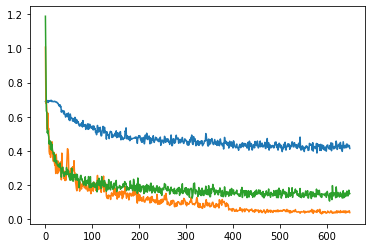

In [ ]:
plt.plot(train_losses_m)
plt.plot(train_losses_r)
plt.plot(train_losses_c)


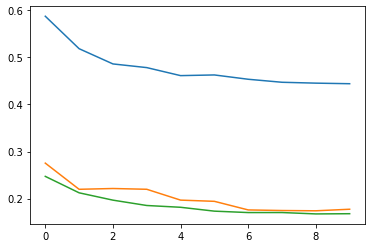

In [ ]:
plt.plot(val_losses_m)
plt.plot(val_losses_r)
plt.plot(val_losses_c)

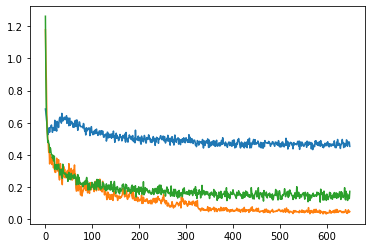

In [ ]:
plt.plot(train_losses_m)
plt.plot(train_losses_r)
plt.plot(train_losses_c)

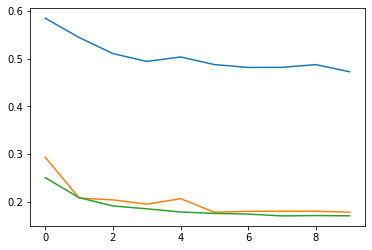

In [ ]:
plt.plot(val_losses_m)
plt.plot(val_losses_r)
plt.plot(val_losses_c)

#postprocess

In [11]:
def prepareimg(nms_labels,mask_output,nms_boxes,nms_scores,display=True):
  cls = nms_labels[0]
  mask_one_cls = mask_output[torch.LongTensor(range(mask_output.shape[0])), cls] # [100, 28, 28] get corresponding label mask
  mask_one_cls = mask_one_cls.unsqueeze(1)
  mask_one_cls

  keep=nms_boxes[0]
  x1, y1, x2, y2 = keep[:,0], keep[:,1], keep[:,2], keep[:,3]
  h = y2 - y1
  w = x2 - x1
  
  mask_total = torch.tensor([]).to(current_device)
  for idx in range(mask_output.shape[0]):

      if int(h[idx]) < 2 or int(w[idx]) < 2:
          continue
      mask_one = mask_one_cls[idx].unsqueeze(0)               # [1, 1, 28, 28]
      # print(mask_one.shape)
      mask_rescaled = F.interpolate(mask_one, size = (int(h[idx]), int(w[idx])), mode='bilinear', align_corners=True).squeeze()   # [h, w]

      # Padding
      p2d = (int(x1[idx]), 1088-int(x1[idx])-int(w[idx]), int(y1[idx]), 800-int(y1[idx])-int(h[idx]))
      mask_padded = F.pad(mask_rescaled, p2d).unsqueeze(0)    # [800, 1088]
      mask_total = torch.cat((mask_total,mask_padded), dim=0) # [100, 800, 1088]

  # Convert to binary form
  positive_idx = torch.where(mask_total >= 0.5)
  negative_idx = torch.where(mask_total < 0.5)
  mask_total[positive_idx] = 1
  mask_total[negative_idx] = 0
  if display==False:
    return display_instance(nms_scores[0], mask_total, nms_labels[0], images[0], keep[:,:4],5,display=display)
  else:
    display_instance(nms_scores[0], mask_total, nms_labels[0], images[0], keep[:,:4],5,display=display)



def display_instance(scores, masks, labels, image, boxes,topK,display=True):
    image = ((np.copy(image.cpu().numpy().transpose(1, 2, 0)) * np.array([0.229, 0.224, 0.225]) +np.array([0.485, 0.456, 0.406])) * 255).astype(np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # print(scores.shape,labels.shape,boxes.shape,masks.shape)
    # return
    
    if masks.shape[0]!=scores.shape[0]:
      scores=scores[:masks.shape[0]]
      labels=labels[:masks.shape[0]]
      boxes=boxes[:masks.shape[0]]

    # labels_idx= labels != 0
    # scores=scores[labels_idx]
    # labels=labels[labels_idx]
    # boxes=boxes[labels_idx]
    # masks=masks[labels_idx]

    _, idx_sorted = torch.sort(scores, descending=True)
    scores = scores[idx_sorted]
    scores = scores[:topK]
    labels = labels[idx_sorted]
    labels = labels[:topK]
    boxes = boxes[idx_sorted]
    boxes = boxes[:topK]
    masks = masks[idx_sorted]
    masks = masks[:topK]

    idx_filter=scores>0.9
    scores = scores[idx_filter]
    masks = masks[idx_filter]
    boxes = boxes[idx_filter]
    labels = labels[idx_filter]

    # print(labels)
    # return

    if display==False:
      return scores, masks, labels, boxes
    scores, masks, labels, boxes=scores.detach().cpu().numpy(),masks.detach().cpu().numpy(), labels.detach().cpu().numpy(),  boxes.detach().cpu().numpy()
    
    class_names = {0: "vehicle", 1: 'people', 2: 'animal'}

    # Number of instances
    N = boxes.shape[0]

    # Generate random colors
    def random_colors(N, bright=True):
      brightness = 1.0 if bright else 0.7
      hsv = [(i / N, 1, brightness) for i in range(N)]
      colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
      random.shuffle(colors)
      return colors
    colors = random_colors(N)

    # Plot bounding boxes
    for i in range(N):
        color = colors[i]
        # Bounding box
        x1, y1, x2, y2 = boxes[i,:]
        w = x2 - x1
        h = y2 - y1

        if labels[i] == 1:    
            # continue
            color_box = 'g'
        elif labels[i] == 2:
            color_box = 'b'  
        elif labels[i] == 0:  
            color_box = 'r'

        ax = plt.gca()
        rect = patches.Rectangle((x1,y1),w,h,linewidth=2,edgecolor=color_box,facecolor='none')
        ax.add_patch(rect)

        # Label
        label = labels[i]
        score = scores[i] if scores is not None else None
        label_name = class_names[int(label)]
        caption = "{} {:.3f}".format(label_name, score) if score else label_name
        ax.text(x1, y1, caption, color='w', size=12, backgroundcolor="black")
        # ax.text(x1, y1, caption,
        #         color='w', size=12, backgroundcolor="b")


        # Mask
        mask = masks[i].astype(np.uint32)
        def apply_mask(image, mask, color, alpha=0.5):

          for c in range(3):
              image[:, :, c] = np.where(mask == 1,
                                        image[:, :, c] *
                                        (1 - alpha) + alpha * color[c] * 255,
                                        image[:, :, c])
          return image
        image = apply_mask(image, mask, color)
        ax.imshow(image.astype(np.uint8))

    plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


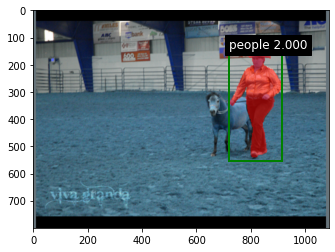

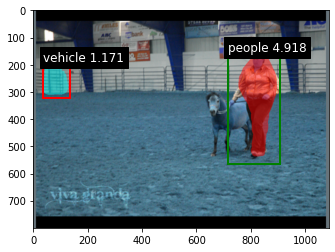

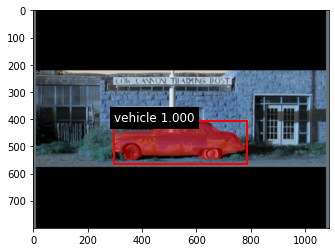

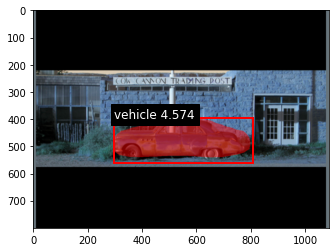

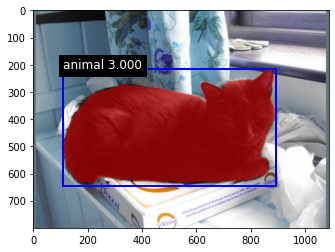

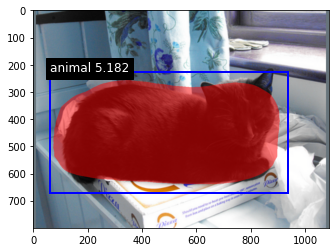

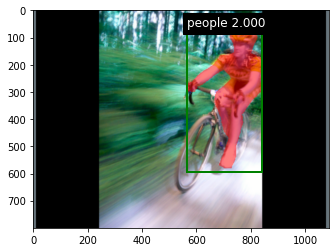

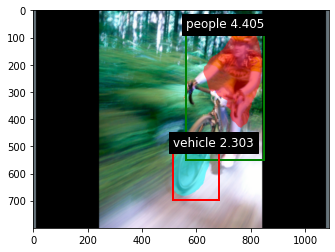

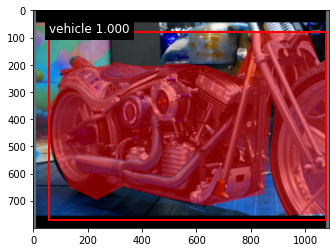

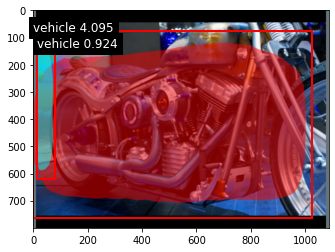

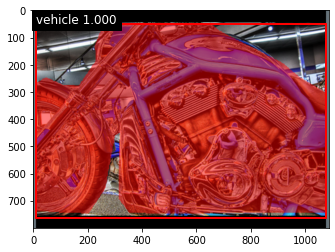

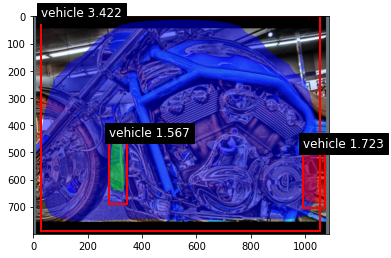

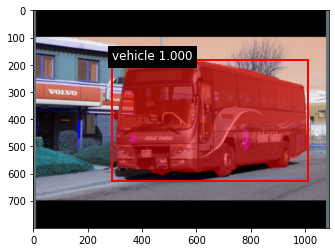

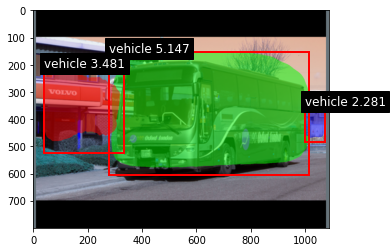

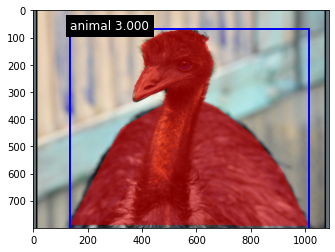

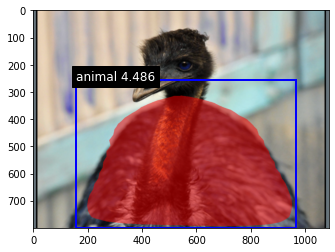

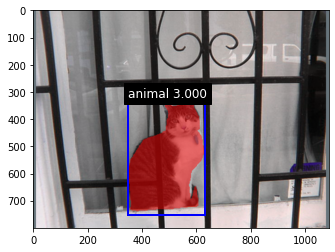

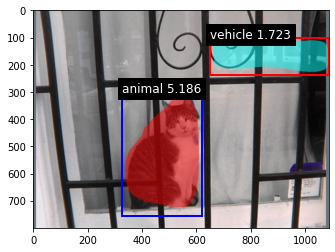

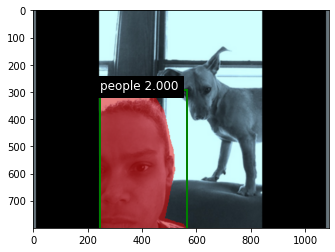

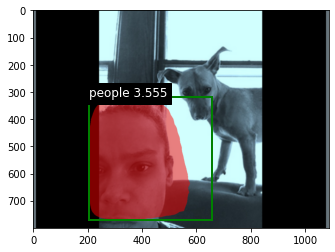

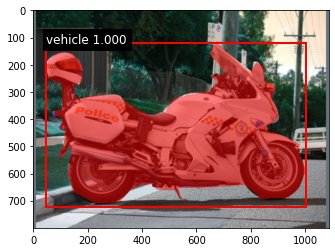

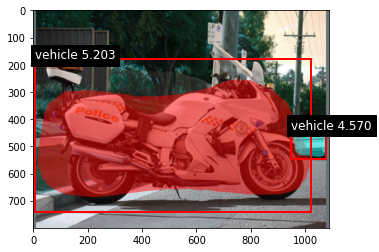

In [13]:
mask_rcnn=MaskRCNN().to(device)

mask_rcnn.load_state_dict(torch.load('modelsimon2.pth'))


# device = "cuda"
# backbone.to(device)
# rpn.to(device)

# for param in backbone.parameters():
    # param.requires_grad = False
# for param in rpn.parameters():
#     param.requires_grad = False
mask_rcnn.eval()

keep_topK = 200
l = 10
lr = 0.0003

batch_size = 1
# train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
# train_loader = train_build_loader.loader()
test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = test_build_loader.loader()



#choose plot whether gt or pred
plotting="pred"
# plotting="gt"
count=0
for i,batch in enumerate((test_loader)):

        images, labels, masks, bboxes_list, indexes = batch
        labels_copy=labels
        images = images.to(device)

        bboxes_list = [b.to(device) for b in bboxes_list]
        backout = backbone(images)

        # The RPN implementation takes as first argument the following image list
        im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
        # Then we pass the image list and the backbone output through the rpn
        rpnout = rpn(im_lis, backout)

        #The final output is
        # A list of proposal tensors: list:len(bz){(keep_topK,4)}
        proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
        # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
        fpn_feat_list= list(backout.values())

        feature_vectors_box = mask_rcnn.box_head.MultiScaleRoiAlign(fpn_feat_list,proposals)
        # class_logits, box_pred = box_head.forward(feature_vectors_box)        
        feature_vectors_mask = MultiScaleRoiAlign(fpn_feat_list,proposals,P=14)
        # mask_output = mask_head.forward(feature_vectors_mask)

        class_logits, box_pred, mask_output = mask_rcnn.forward(feature_vectors_box, feature_vectors_mask)
        nms_boxes, nms_scores, nms_labels = mask_rcnn.box_head.postprocess_detections(class_logits, box_pred, proposals, conf_thresh=1, keep_num_preNMS=100, keep_num_postNMS=3)
        
        # print(fpn_feat_list[0].shape,nms_boxes[0].shape)

        feature_vectors_mask = MultiScaleRoiAlign(fpn_feat_list,nms_boxes,P=14)
        class_logits2, box_pred2, mask_output = mask_rcnn.forward(feature_vectors_box, feature_vectors_mask)

        # print(fpn_feat_list[0].shape,proposals[0].shape,feature_vectors_mask.shape,nms_boxes[0].shape, nms_scores[0].shape, nms_labels[0].shape)
        labels,regressor_target = mask_rcnn.box_head.create_ground_truth(proposals,labels,bboxes_list)

        mask_target = mask_rcnn.mask_head.create_ground_truth(box_pred,labels,proposals,bboxes_list,masks)
        # print(mask_output.shape)
        loss_box, loss_c, loss_r = mask_rcnn.box_head.compute_loss(class_logits, box_pred, labels, regressor_target, l=10)
        
        if plotting=="pred":
          display_instance(labels_copy[0], masks[0], labels_copy[0]-1, images[0], bboxes_list[0],1,True)
          prepareimg(nms_labels,mask_output,nms_boxes,nms_scores,display=True)
        else:
          display_instance(labels_copy[0], masks[0], labels_copy[0]-1, images[0], bboxes_list[0],1,True)

        count+=1
        if count>10:
          break


##box map

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


0 : 0.5042991042137146
1 : 0.7142515182495117
2 : 0.7645288109779358
mAP 0.6610264778137207


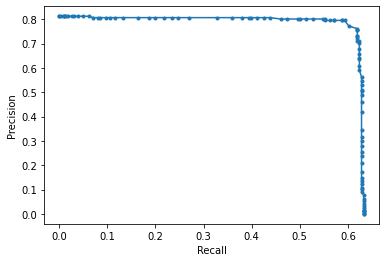

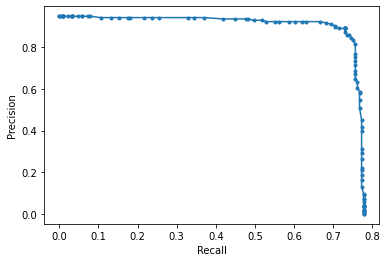

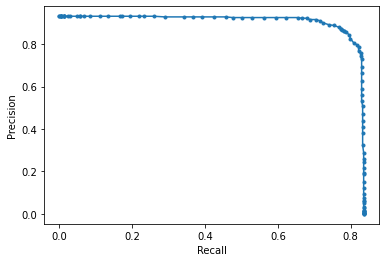

In [ ]:
mask_rcnn=MaskRCNN().to(device)

mask_rcnn.load_state_dict(torch.load('modelsimon2.pth'))


# device = "cuda"
# backbone.to(device)
# rpn.to(device)

# for param in backbone.parameters():
    # param.requires_grad = False
# for param in rpn.parameters():
#     param.requires_grad = False


keep_topK = 200
l = 10
lr = 0.0003

batch_size = 1
# train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
# train_loader = train_build_loader.loader()
test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()
trues_per_batch=[]
positives_per_batch=[]
match_values=[]
score_values=[]

with torch.no_grad(): 
    for i,batch in enumerate((test_loader)):
        images, labels, masks, bboxes_list, indexes = batch

        labels_raw = [item.to(device) for item in labels]
        images = images.to(device)

        bboxes_list = [b.to(device) for b in bboxes_list]
        backout = backbone(images)

        # The RPN implementation takes as first argument the following image list
        im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
        # Then we pass the image list and the backbone output through the rpn
        rpnout = rpn(im_lis, backout)

        #The final output is
        # A list of proposal tensors: list:len(bz){(keep_topK,4)}
        proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
        # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
        fpn_feat_list= list(backout.values())

        feature_vectors_box = mask_rcnn.box_head.MultiScaleRoiAlign(fpn_feat_list,proposals)
        # class_logits, box_pred = box_head.forward(feature_vectors_box)        
        feature_vectors_mask = MultiScaleRoiAlign(fpn_feat_list,proposals,P=14)
        # mask_output = mask_head.forward(feature_vectors_mask)

        class_logits, box_pred, mask_output = mask_rcnn.forward(feature_vectors_box, feature_vectors_mask)
        nms_boxes, nms_scores, nms_labels = mask_rcnn.box_head.postprocess_detections(class_logits, box_pred, proposals, conf_thresh=1, keep_num_preNMS=50, keep_num_postNMS=1)
        
        # print(fpn_feat_list[0].shape,nms_boxes[0].shape)

        feature_vectors_mask = MultiScaleRoiAlign(fpn_feat_list,nms_boxes,P=14)
        class_logits2, box_pred2, mask_output = mask_rcnn.forward(feature_vectors_box, feature_vectors_mask)

        # print(fpn_feat_list[0].shape,proposals[0].shape,feature_vectors_mask.shape,nms_boxes[0].shape, nms_scores[0].shape, nms_labels[0].shape)
        # labels,regressor_target,mask_target =mask_rcnn.mask_head.create_ground_truth(proposals,labels,bboxes_list,masks)
        labels,regressor_target = mask_rcnn.box_head.create_ground_truth(proposals,labels,bboxes_list)
        proposal_labels = labels
        mask_target = mask_rcnn.mask_head.create_ground_truth(box_pred,labels,proposals,bboxes_list,masks)
        # print(mask_output.shape)
        loss_box, loss_c, loss_r = mask_rcnn.box_head.compute_loss(class_logits, box_pred, labels, regressor_target, l=10)


        matches, scores, num_trues, num_positives =  mask_rcnn.box_head.evaluation(nms_boxes, nms_scores, nms_labels,bboxes_list, labels_raw)
        trues_per_batch.append(num_trues)
        positives_per_batch.append(num_positives)
        match_values.append(matches)
        score_values.append(scores)

        start_id = 0
        for i in range(images.shape[0]):
          background = proposal_labels[start_id:start_id + proposals[i].shape[0]] == 0
          background = background.squeeze()
          proposals_fg = proposals[i][~background]
          labels_fg = proposal_labels[start_id:start_id +proposals[i].shape[0]][~background] - 1
          # print("groudtruth")
          # plt.imshow(out_img)
          # plt.show()

          start_id += proposals[i].shape[0]
        # print("afternms")
        # plt.imshow( out_img)
        # plt.show()
trues_per_batch = torch.stack(tuple(trues_per_batch))
positives_per_batch = torch.stack(tuple(positives_per_batch))
trues_per_batch = torch.sum(trues_per_batch, dim=0)
positives_per_batch = torch.sum(positives_per_batch, dim=0)
match_values = torch.cat(tuple(match_values))
score_values = torch.cat(tuple(score_values))



# calculate mAP
list_sorted_recall,list_sorted_precision,list_AP = [],[],[]

AP = 0
cnt = 0
class_AP=[]
for class_idx in range(3):
  if torch.sum(match_values[:, class_idx]) > 0:
    area, sorted_recall, sorted_precision = mask_rcnn.box_head.ap(match_values[:, class_idx],score_values[:, class_idx],trues_per_batch[class_idx],positives_per_batch[class_idx],threshold=0.5)
    AP += area
    print(cnt,":",area)
    cnt += 1
    list_sorted_recall.append(sorted_recall)
    list_sorted_precision.append(sorted_precision)
    list_AP.append(area)
    class_AP.append(area/cnt)
list_sorted_precision[0][-1]=0
list_sorted_precision[1][-1]=0
list_sorted_precision[2][-1]=0

mAP =  AP / cnt
print('mAP {}'.format(mAP))

for i in range(len(list_sorted_recall)):
  plt.figure()
  plt.plot(list_sorted_recall[i], list_sorted_precision[i], '.-')
  plt.xlabel('Recall')
  plt.ylabel('Precision')


##mask map


In [17]:
mask_rcnn=MaskRCNN().to(device)

mask_rcnn.load_state_dict(torch.load('modelCodeSubmission.pth'))


# device = "cuda"
# backbone.to(device)
# rpn.to(device)

# for param in backbone.parameters():
    # param.requires_grad = False
# for param in rpn.parameters():
#     param.requires_grad = False


keep_topK = 200
l = 10
lr = 0.0003

batch_size = 1
# train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
# train_loader = train_build_loader.loader()
test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = test_build_loader.loader()


APs = []

cumulative_correct=[0]
cumulative_wrong=[0]
cumulative_p_count=[0]
cumulative_gt_count=[0]

trues_per_batch=[]
positives_per_batch=[]
match_values=[]
score_values=[]
with torch.no_grad(): 
    for i,batch in enumerate((test_loader)):
        images, labels, masks, bboxes_list, indexes = batch
        
        labels_copy=labels
        images = images.to(device)

        bboxes_list = [b.to(device) for b in bboxes_list]
        backout = backbone(images)

        # The RPN implementation takes as first argument the following image list
        im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
        # Then we pass the image list and the backbone output through the rpn
        rpnout = rpn(im_lis, backout)

        #The final output is
        # A list of proposal tensors: list:len(bz){(keep_topK,4)}
        proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
        # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
        fpn_feat_list= list(backout.values())

        feature_vectors_box = mask_rcnn.box_head.MultiScaleRoiAlign(fpn_feat_list,proposals)
        # class_logits, box_pred = box_head.forward(feature_vectors_box)        
        feature_vectors_mask = MultiScaleRoiAlign(fpn_feat_list,proposals,P=14)
        # mask_output = mask_head.forward(feature_vectors_mask)

        class_logits, box_pred, mask_output = mask_rcnn.forward(feature_vectors_box, feature_vectors_mask)
        nms_boxes, nms_scores, nms_labels = mask_rcnn.box_head.postprocess_detections(class_logits, box_pred, proposals, conf_thresh=1, keep_num_preNMS=50, keep_num_postNMS=1)
        
        # print(fpn_feat_list[0].shape,nms_boxes[0].shape)

        feature_vectors_mask = MultiScaleRoiAlign(fpn_feat_list,nms_boxes,P=14)
        class_logits2, box_pred2, mask_output = mask_rcnn.forward(feature_vectors_box, feature_vectors_mask)

        # print(nms_labels[0].shape,mask_output[0].shape,nms_boxes[0].shape,nms_scores[0].shape)
        t_scores, t_masks, t_labels, t_boxes=prepareimg(nms_labels,mask_output,nms_boxes,nms_scores,display=False)
        # print(t_scores.shape, t_masks.shape, t_labels.shape, t_boxes.shape)
        if t_scores.shape[0]==0:
          continue

        pred_boxes, pred_class_ids, pred_scores, pred_masks=t_boxes.detach().cpu().numpy(),t_labels.detach().cpu().numpy(),t_scores.detach().cpu().numpy(), t_masks.detach().cpu().numpy()
        gt_boxes, gt_class_ids, gt_masks=bboxes_list[0],labels_copy[0]-1,masks[0].detach().cpu().numpy()


        matches, scores, num_trues, num_positives = mask_rcnn.mask_head.evaluation(pred_masks,pred_scores,pred_class_ids,gt_masks,gt_class_ids,iou_thresh= 0.5)

        trues_per_batch.append(num_trues)
        positives_per_batch.append(num_positives)
        match_values.append(matches)
        score_values.append(scores)


        # print(precisions, recalls,overlaps)

        # if i>300:
        #   break

trues_per_batch = torch.stack(tuple(trues_per_batch))
positives_per_batch = torch.stack(tuple(positives_per_batch))
trues_per_batch = torch.sum(trues_per_batch, dim=0)
positives_per_batch = torch.sum(positives_per_batch, dim=0)
match_values = torch.cat(tuple(match_values))
score_values = torch.cat(tuple(score_values))



# calculate mAP
list_sorted_recall,list_sorted_precision,list_AP = [],[],[]

AP = 0
cnt = 0
class_AP=[]
for class_idx in range(3):
  if torch.sum(match_values[:, class_idx]) > 0:
    area, sorted_recall, sorted_precision = mask_rcnn.mask_head.ap(match_values[:, class_idx],score_values[:, class_idx],trues_per_batch[class_idx],positives_per_batch[class_idx],threshold=0.5)
    AP += area
    print(cnt,":",area)
    cnt += 1
    list_sorted_recall.append(sorted_recall)
    list_sorted_precision.append(sorted_precision)
    list_AP.append(area)
    class_AP.append(area/cnt)
list_sorted_precision[0][-1]=0
list_sorted_precision[1][-1]=0
list_sorted_precision[2][0]=0
list_sorted_precision[2]=sorted(list_sorted_precision[2],reverse=True)

mAP =  AP / cnt
print('mAP {}'.format(mAP))

for i in range(len(list_sorted_recall)):
  plt.figure()
  plt.plot(list_sorted_recall[i], list_sorted_precision[i], '.-')
  plt.xlabel('Recall')
  plt.ylabel('Precision')


FileNotFoundError: ignored